In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 17}

# matplotlib.rc('font', **font)

import scipy.integrate as integrate
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Analysis of the impact of the value of g and g'

We have seen that the SDE: 
$$
dX = -U'(X) dt + \sqrt{2 \tau} dW(t)
$$

and 

$$
dY = -U'(Y) g(Y) ds + \tau g'(Y) ds+ \sqrt{2 \tau g(Y)} dW(t)
$$

have the same invariant distribution. 

We would like to explore whether adding this $g'(y)$ is actually making any difference. 

### Bond potential 
We take back the bound problem to analyse this problem with 
\begin{equation}
\begin{aligned}
&F(x)=-\nabla V(x) \\
&V(x)= \frac{1}{2 x^2} +x^2\\
 \Rightarrow &F(x)= -\frac{1}{x^3}+2x, \\
 \Rightarrow &f(x)= \nabla V(x) = \frac{1}{x^3}-2x,
\end{aligned}
\end{equation}
and we have that : $f'(x) = -(\frac{3}{x^4}+2)$.

The choice of g is usually to take the inverse of the gradient: 
\begin{equation}
     g(x) = \frac{1}{\|f(x)\|},
\end{equation}
where $f(x) = U'(x)$.
To avoid crazy values of $g(x)$, one can bound the values of $g(x)$ by using: 
\begin{equation}
    g(x) = \frac{\frac{1}{M}\sqrt{\|f(x)\|^2+m^2}+1}{\sqrt{ \|f(x)\|^2+m^2}},
\end{equation}
where $m=\frac{\Delta t_{\min}}{\Delta s}$ and $M= \frac{\Delta t_{\max}}{\Delta s}$. We also require the value of $g'(x)$, which is given by: 
\begin{equation}
\begin{aligned}
    g'(x) = - \frac{ f(x)f'(x)}{(f(x)^2 + m^2)^{3/2}}.
\end{aligned}
\end{equation}
Note that $g'(x)$ only depends on $\Delta t_{\min}$.

### Explore the values of G(x), nabla G(x), and its impact on the convergence towards the invariant distribution

#### Bond potential

##### Try and test the code here  
In the cell below, one can set up the parameter of the function $g$ and $g'(x)$. 

- Number of statistical sampling: 
n_samples = 1

- Final time at which we look at the solution:
T=10.0

- Value of $\tau$:
tau=0.1

- Value of initial time step h:
dt=0.01

- Bound of the maximum and minimum time steps we would like to reach:
dtbounds=np.array([0.0001,10])

- Multiplicative term to the correction in $g'(x)$.
gcorrection=1

Parameters on g'(x) that have seems to work: 
- dt=1, dtbounds = np.array([0.001,0.01])

 

In [1]:
from numba import jit,njit,vectorize, float64, int32, boolean
import numba as nb
import numpy as np

##############
# Parameters #
##############
M=10
m=0.01
# includeD=False # if 1 include divergence term


########################
# Potential parameters #
########################

def U(x):
    """
    potential of -the infinite double well
    """
    x2 = x*x
    
    return (1/(2*x2)+x2)
    
# define the gradV function 
@njit(float64(float64))
def Up(x):
    res = -1/(x*x*x)+2*x
    return res

########################
#  Adaptive function G #
########################
@njit(float64(float64))
def getg(x): #,dtmin, dtmax, R):
    x6 = np.power(x,6)
    xi = np.sqrt(m*m+x6)
    g=1./(1./M+1./xi)
    # g=1
    return g

@njit(float64(float64))
def getgprime(x):
    x6 = np.power(x,6);
    x5 = x6/x
    xi = np.sqrt(x6+m*m);
    g =1./(1./M + 1./xi);
    gprime= 3*x5*np.power(g,2)/np.power(xi,3)
    # gprime=0
    return gprime

####################
#  Numerical method#
####################  

@njit(float64[:](float64,float64,float64,float64,float64))
def one_traj_ada(T,dt,tau,includeD,ada):
    """
    Run the simulation for one sample path
    Input
    -----
    Ntot: int
        Number of steps to take to get to Tf with dt
    dt: float 
        Value of time increment. Is 1/N.
    tau: float 
        Is in the multiplicative term of the SDE in sqrt(2 \tau dt). 
    Return
    ------
    x: float
        Value of X(T) as approximated by the numerical scheme chosen
    """

    x = 2 # initial value
    t=0 # initialise time at t=0
    count=0.
    while t<T:
        # Compute the values of f, g, g' and g*dt 
        #########################################
        f = -Up(x)
        g= getg(x)
        # Condition if we want to use the adaptive steps
        ###############################################
        gdt=dt 
        if ada==1:
            gdt=g*dt
        # Compute the values of next step 
        #################################
        b1 = np.random.normal(0,1)
        x+=f*gdt+np.sqrt(tau*gdt*2)*b1
        if includeD==1:
            gp=getgprime(x)/g
            x +=dt*tau*gp
        t+=gdt
        count+=1.
    res=np.array([x,count])
    return (res)

####################################################
#  Numerical method ran over M statistical samples #
####################################################

@njit(parallel=True)
def nsample_ada(n_samples,T,dt,tau,includeD,ada): # Function is compiled and runs in machine code

    """
    Input
    -------
    n_samples: int
        Number of sample to draw
    T: int 
        Final time
    dt: float
        Size of the time discretization 
    tau: float
        Value of the temperature of the DW SDE (+ sqrt(2*tau)*dW)
    method: function
        Numerical scheme used for the DW SDE
    Return
    -------
    y_final: np.array
        Array of shape (M,). Sample of numerical approximation of the DW SDE at time T
    
    """

    xcount_list=np.zeros((n_samples,2))
    for i in range(n_samples):
        xcount =one_traj_ada(T,dt,tau,includeD,ada)
        xcount_list[i,::]=xcount
    return xcount_list

# compile
nsample_ada(1,1,0.1,0.1,1,1) 


array([[-58.10640272,   3.        ]])

In [12]:
n_samples=10**5
T=50
tau=0.1
dt=0.01

### Compile and run 
###################
%time ycountwithG= nsample_ada(n_samples,T,dt,tau,1,1)
# %time ycountwithoutG= nsample_ada(n_samples,T,dt,tau,0,1)
# %time ycountnoada= nsample_ada(n_samples,T,dt,tau,0,0)


CPU times: user 35min 48s, sys: 1.92 s, total: 35min 50s
Wall time: 3min 3s


In [12]:
ywithG=ycountwithG[::,0]
countwithG = ycountwithG[::,1]
ywithoutG=ycountwithoutG[::,0]
countwithoutG = ycountwithoutG[::,1]
ynoada=ycountnoada[::,0]
countnoada = ycountnoada[::,1]

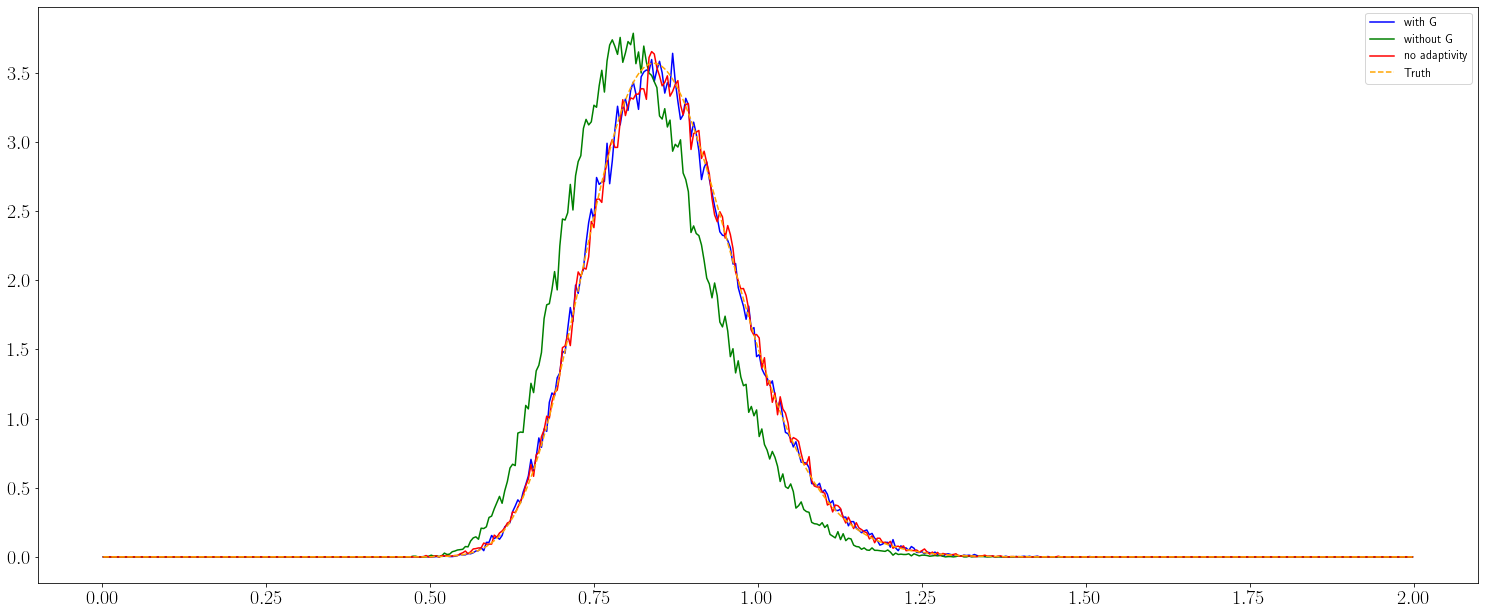

In [13]:

upperbound=2

fig, ((ax1))= plt.subplots(1,1,figsize=(25,10))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

### Plot with the correction term G
########-----#######################
histogram,bins = np.histogram(ywithG,bins=500,range=[0,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax1.plot(midx,histogram,label="with G",color="blue")


### Plot without the correction term G
########-------#######################
histogram,bins = np.histogram(ywithoutG,bins=500,range=[0,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax1.plot(midx,histogram,label="without G",color="green")


### Plot with normal sde 
########-----#######################
histogram,bins = np.histogram(ynoada,bins=500,range=[0,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax1.plot(midx,histogram,label="no adaptivity",color="red")


## plot true
rho = np.exp(- (U(midx)/tau))
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
ax1.plot(midx,rho,'--',label='Truth',color="orange")
ax1.legend()


<BarContainer object of 100 artists>

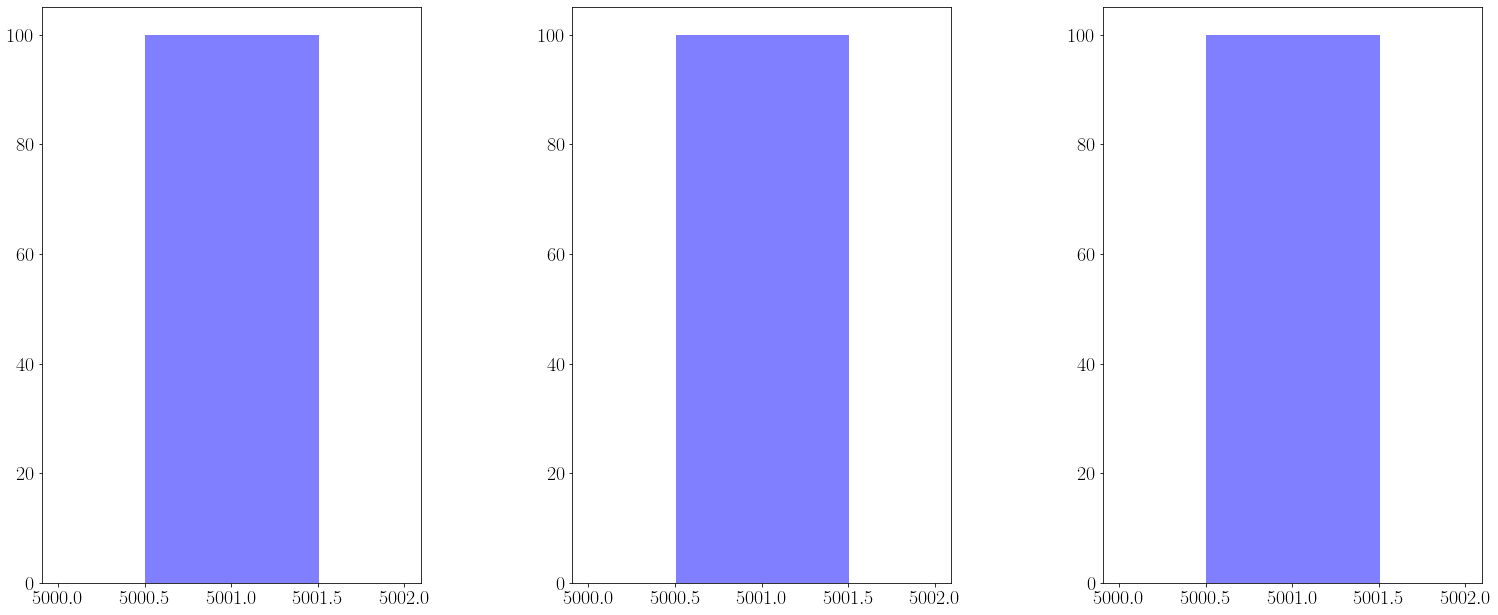

In [14]:


fig, ((ax1,ax2,ax3))= plt.subplots(1,3,figsize=(25,10))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

### Plot with the correction term G
########-----#######################
var = countwithG
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(countwithG,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax1.bar(midx,histogram,width=(upperbound-lowerbound)/nbins+1,color="blue",label="Ada with G",alpha=0.5)


### Plot without the correction term G
########-------#######################
var = countwithoutG
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(countwithoutG,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax2.bar(midx,histogram,width=(upperbound-lowerbound)/nbins+1,color="blue",label="Ada without G",alpha=0.5)


### Plot with normal sde 
########-----#######################
var = countnoada
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(countnoada,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax3.bar(midx,histogram,width=(upperbound-lowerbound)/nbins+1,color="blue",label="No ada",alpha=0.5)




### Look at how fast we reach the invariant distribution

In [4]:
from numba import jit,njit,vectorize, float64, int32, boolean
import numba as nb
import numpy as np

##############
# Parameters #
##############
M=10
m=0.01
# includeD=False # if 1 include divergence term


########################
# Potential parameters #
########################

def U(x):
    """
    potential of -the infinite double well
    """
    x2 = x*x
    
    return (1/(2*x2)+x2)
    
# define the gradV function 
@njit(float64(float64))
def Up(x):
    res = -1/(x*x*x)+2*x
    return res

########################
#  Adaptive function G #
########################
@njit(float64(float64))
def getg(x): #,dtmin, dtmax, R):
    x6 = np.power(x,6)
    xi = np.sqrt(m*m+x6)
    g=1./(1./M+1./xi)
    # g=1
    return g

@njit(float64(float64))
def getgprime(x):
    x6 = np.power(x,6);
    x5 = x6/x
    xi = np.sqrt(x6+m*m);
    g =1./(1./M + 1./xi);
    gprime= 3*x5*np.power(g,2)/np.power(xi,3)
    # gprime=0
    return gprime

###################################
# * Using the hessian definition *#
###################################
@njit(float64(float64))
def getg_hessian(x): #,dtmin, dtmax, R):
    gi2 = np.power(x,8)/9
    xi = np.sqrt(m*m+gi2)
    g=1./(1./M+1./xi)
    return g

@njit(float64(float64))
def getgprime_hessian(x):
    gi2 = np.power(x,8)/9
    xi = np.sqrt(gi2+m*m)
    x7=gi2/x*4
    Mxi =np.power((M+xi),2)
    gprime= x7*M*M/(Mxi*xi)
    return gprime

####################
#  Numerical method#
####################  

@njit(float64(float64,float64,float64,float64))
def one_traj_ada(T,dt,tau,include_ada):
    """
    Run the simulation for one sample path
    Input
    -----
    Ntot: int
        Number of steps to take to get to Tf with dt
    dt: float 
        Value of time increment. Is 1/N.
    tau: float 
        Is in the multiplicative term of the SDE in sqrt(2 \tau dt). 
    Return
    ------
    x: float
        Value of X(T) as approximated by the numerical scheme chosen
    """

    x = 2 # initial value
    t=0 # initialise time at t=0
    count=0.
    while t<T:
        # Compute the values of f, g, g' and g*dt 
        #########################################
        f = -Up(x)
        g=1
        gp=0
        if include_ada==1:
            g=getg_hessian(x)
            gp=getgprime_hessian(x)
        elif include_ada==2:
            g=getg(x)
            gp=getgprime(x)
        gdt=g*dt

        # Compute the values of next step 
        #################################
        b1 = np.random.normal(0,1)
        x+=f*gdt+np.sqrt(tau*gdt*2)*b1+dt*tau*gp

        t+=dt
        count+=1.
    
    return (x)

####################################################
#  Numerical method ran over M statistical samples #
####################################################

@njit(parallel=True)
def nsample_ada(n_samples,T,dt,tau,include_ada): # Function is compiled and runs in machine code

    """
    Input
    -------
    n_samples: int
        Number of sample to draw
    T: int 
        Final time
    dt: float
        Size of the time discretization 
    tau: float
        Value of the temperature of the DW SDE (+ sqrt(2*tau)*dW)
    method: function
        Numerical scheme used for the DW SDE
    Return
    -------
    y_final: np.array
        Array of shape (M,). Sample of numerical approximation of the DW SDE at time T
    
    """

    x_list=np.zeros((n_samples,1))
    for i in range(n_samples):
        x =one_traj_ada(T,dt,tau,include_ada)
        x_list[i]=x
    return x_list

# compile
nsample_ada(1,1,0.1,0.1,1,1) 


array([[0.84528221]])

In [5]:
n_samples=10**2
T=50
tau=0.1
dt=0.01

### Compile and run 
###################
%time ycountwithG= nsample_ada(n_samples,T,dt,tau,1,1)
%time ycountnoada= nsample_ada(n_samples,T,dt,tau,0,0)

CPU times: user 382 ms, sys: 0 ns, total: 382 ms
Wall time: 126 ms
CPU times: user 347 ms, sys: 0 ns, total: 347 ms
Wall time: 64.1 ms


CPU times: user 443 ms, sys: 0 ns, total: 443 ms
Wall time: 275 ms
CPU times: user 448 ms, sys: 726 µs, total: 449 ms
Wall time: 135 ms
CPU times: user 887 ms, sys: 0 ns, total: 887 ms
Wall time: 723 ms
CPU times: user 505 ms, sys: 473 µs, total: 506 ms
Wall time: 299 ms
CPU times: user 1.15 s, sys: 8.03 ms, total: 1.16 s
Wall time: 984 ms
CPU times: user 617 ms, sys: 3.8 ms, total: 621 ms
Wall time: 423 ms
CPU times: user 1.6 s, sys: 724 µs, total: 1.6 s
Wall time: 1.41 s
CPU times: user 752 ms, sys: 471 µs, total: 752 ms
Wall time: 570 ms
CPU times: user 4.18 s, sys: 0 ns, total: 4.18 s
Wall time: 4 s
CPU times: user 1.91 s, sys: 3.97 ms, total: 1.92 s
Wall time: 1.73 s
CPU times: user 13.6 s, sys: 20.1 ms, total: 13.6 s
Wall time: 13.4 s
CPU times: user 6.1 s, sys: 15.5 ms, total: 6.12 s
Wall time: 5.82 s


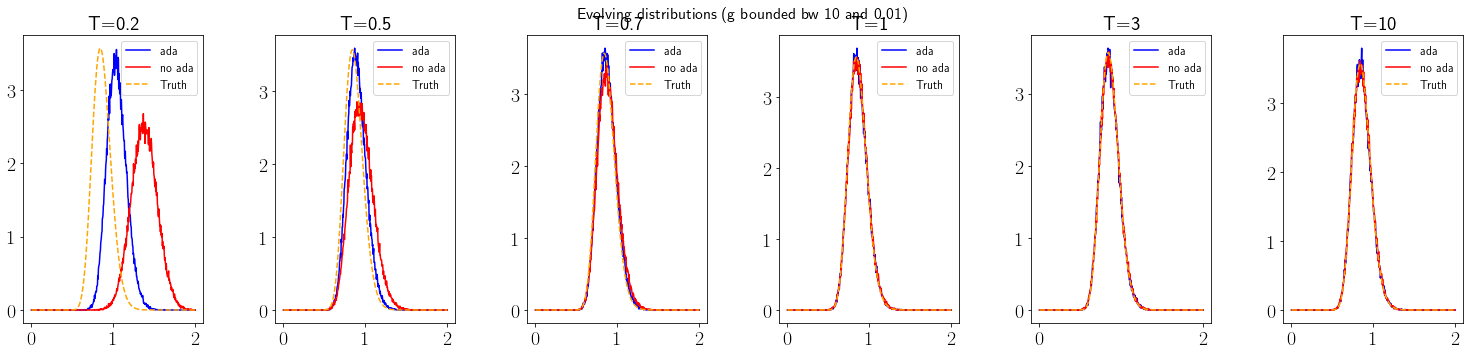

In [9]:

upperbound=2
n_samples=100000
tau=0.1
dt=0.01

Tf = [0.2,0.5,0.7,1,3,10]
N=len(Tf)
fig, ((axs))= plt.subplots(1,N,figsize=(25,5))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle('Evolving distributions (g bounded bw 10 and 0.01)', fontsize=16)
for i in range(N):

    T = Tf[i]
    %time ywithG= nsample_ada(n_samples,T,dt,tau,1,1)
    %time ynoada= nsample_ada(n_samples,T,dt,tau,0,0)

    ### Plot with the correction term G
    ########-----#######################
    histogram,bins = np.histogram(ywithG,bins=500,range=[0,upperbound], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    axs[i].plot(midx,histogram,label="ada",color="blue")

    ### Plot with normal sde 
    ########-----#######################
    histogram,bins = np.histogram(ynoada,bins=500,range=[0,upperbound], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    axs[i].plot(midx,histogram,label="no ada",color="red")

    ## plot true
    rho = np.exp(- (U(midx)/tau))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
    axs[i].plot(midx,rho,'--',label='Truth',color="orange")

    axs[i].legend()
    axs[i].set_title('T='+str(T))